In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/MyDrive/ieor-project1/dataset

cluster_1			history_rnn_cluster2.csv  public_holidays
cluster_2			history_rnn_cluster3.csv  results_rnn_cluster1.csv
cluster_3			history_rnn_cluster4.csv  results_rnn_cluster2.csv
cluster_4			mape_rnn_cluster1.csv	  results_rnn_cluster3.csv
combined_explanatory_variables	mape_rnn_cluster2.csv	  results_rnn_cluster4.csv
electricity_price		mape_rnn_cluster3.csv	  temperature
history_rnn_cluster1.csv	mape_rnn_cluster4.csv	  weather


In [4]:
cluster_num = 1 # cluster number

def prepare_mape_values(cluster=1):
    mape_values = pd.read_csv(f'drive/MyDrive/ieor-project1/dataset/mape_rnn_cluster{cluster}.csv')
    # store column names
    first_row = mape_values.columns.tolist()
    mape_values = pd.concat([pd.DataFrame([first_row], columns=mape_values.columns), mape_values], ignore_index=True)
    mape_values.head()
    mape_values.columns = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7']
    for col in mape_values.columns:
        mape_values[col] = pd.to_numeric(mape_values[col], errors='coerce')
    return mape_values

mape_values_q1 = prepare_mape_values(1)
mape_values_q2 = prepare_mape_values(2)
mape_values_q3 = prepare_mape_values(3)
mape_values_q4 = prepare_mape_values(4)

all_mape_values = [mape_values_q1, mape_values_q2, mape_values_q3, mape_values_q4]
cluster_labels = [1, 2, 3, 4]

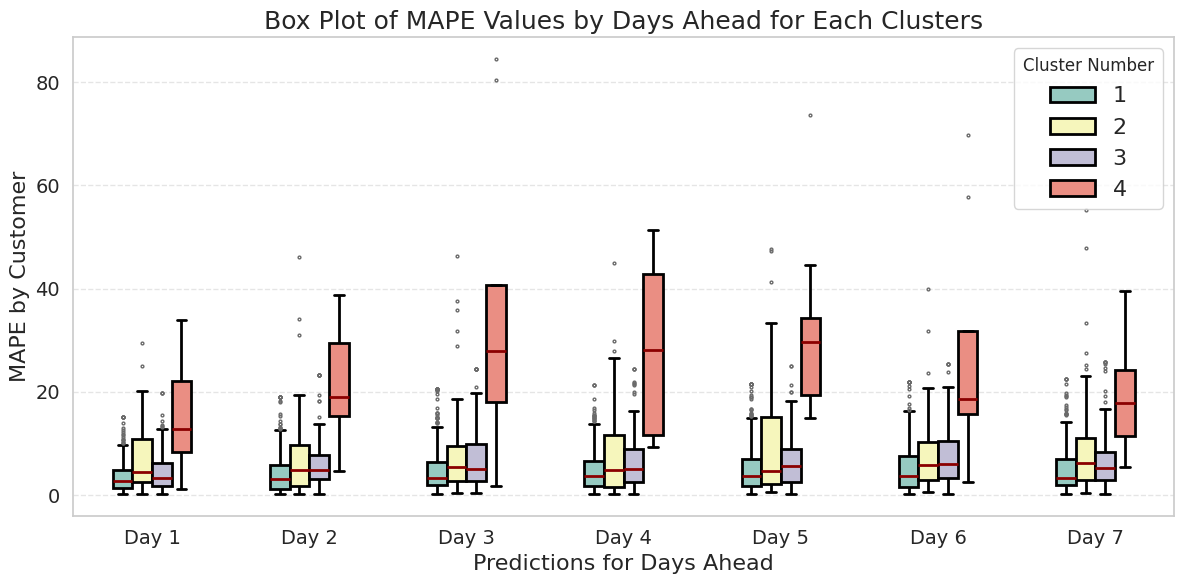

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mape_boxplot_combined(df_list, cluster_labels):
    combined_df = pd.concat(
        [df.assign(cluster_num=label) for df, label in zip(df_list, cluster_labels)],
        ignore_index=True
    )
    for cluster in combined_df["cluster_num"].unique():
        cluster_mask = combined_df["cluster_num"] == cluster
        for col in combined_df.columns[:-1]:  # Exclude 'cluster_num'
            lower = combined_df.loc[cluster_mask, col].quantile(0.025)
            upper = combined_df.loc[cluster_mask, col].quantile(0.975)
            combined_df.loc[cluster_mask, col] = combined_df.loc[cluster_mask, col].clip(lower, upper)

    combined_df = combined_df.sample(n=500, random_state=42)
    melted_df = combined_df.melt(id_vars=['cluster_num'], var_name='Variable', value_name='MAPE')
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        x="Variable", y="MAPE", hue="cluster_num",
        data=melted_df, palette="Set3",
        width=0.5, linewidth=2, fliersize=2,
        boxprops=dict(edgecolor='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        medianprops=dict(color='darkred', linewidth=2)
    )

    plt.title("Box Plot of MAPE Values by Days Ahead for Each Clusters", fontsize=18)
    plt.ylabel("MAPE by Customer", fontsize=16)
    plt.xlabel("Predictions for Days Ahead", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.legend(title="Cluster Number", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_mape_boxplot_combined(all_mape_values, cluster_labels)

In [19]:
def compute_mape_table(df_list, cluster_labels):
    # Combine dataframes and assign cluster labels
    combined_df = pd.concat(
        [df.assign(cluster_num=label) for df, label in zip(df_list, cluster_labels)],
        ignore_index=True
    )

    for cluster in combined_df["cluster_num"].unique():
        cluster_mask = combined_df["cluster_num"] == cluster
        for col in combined_df.columns[:-1]:  # Exclude 'cluster_num'
            lower = combined_df.loc[cluster_mask, col].quantile(0.025)
            upper = combined_df.loc[cluster_mask, col].quantile(0.975)
            combined_df.loc[cluster_mask, col] = combined_df.loc[cluster_mask, col].clip(lower, upper)

    mape_table = combined_df.groupby("cluster_num").mean().T
    mape_table.columns = [f"Cluster {c}" for c in mape_table.columns]  # Rename for clarity

    return mape_table

mape_table = compute_mape_table(all_mape_values, cluster_labels)
mape_table

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Day 1,3.721166,7.234901,5.533722,27.952075
Day 2,4.583188,8.432107,6.524399,30.185188
Day 3,4.947715,8.657031,6.814975,30.535356
Day 4,5.112765,8.253766,6.714810,32.120737
Day 5,5.215150,8.526026,6.893955,31.484759
Day 6,5.287780,8.778980,6.847103,26.830640
Day 7,5.431114,9.774293,6.864547,26.858433


In [6]:
def plot_mape_boxplot(df, cluster_num):
    data = df.copy()
    for col in data.columns:
        lower = data[col].quantile(0.025)
        upper = data[col].quantile(0.975)
        data[col] = data[col].clip(lower, upper)
    data = sampled_data = data.sample(n=500, random_state=42)
    mean_values = data.mean()
    std_values = data.std()
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=data,
        palette="Set3",
        width=0.5,
        linewidth=2,
        fliersize=2,
        boxprops=dict(edgecolor='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        medianprops=dict(color='darkred', linewidth=2)
    )

    for i, (mean, std) in enumerate(zip(mean_values, std_values)):
        ax.text(i, mean + std, f"Mean: {mean:.2f}\nStd: {std:.2f}",
                ha='center', va='bottom', color='white', fontsize=9, weight='bold',
                bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.3'))

    plt.title(f"Box Plot of MAPE Values for Cluster {cluster_num}", fontsize=14)
    plt.ylabel("MAPE")
    plt.tight_layout()
    plt.show()
# plot_mape_boxplot(mape_values_q1, 1)
# plot_mape_boxplot(mape_values_q2, 2)

In [7]:
# days is 365 - 30 - 7 = 328 since we use the first 30 to predict and we predict the last 7
def plot_quarterly_mape_boxplot(df, mape_col='mape', days_per_customer=328, quarters=4, cluster_num=1):
    df = df.copy()
    df[mape_col] = df.mean(axis=1)

    total_rows = df.shape[0]
    if total_rows % days_per_customer != 0:
        print(f"Total rows ({total_rows}) not divisible by days_per_customer ({days_per_customer}).")
    num_customers = total_rows // days_per_customer
    quarter_length = days_per_customer // quarters
    df['customer_id'] = df.index // days_per_customer
    df['day'] = df.index % days_per_customer
    df['quarter'] = (df['day'] // quarter_length + 1).clip(upper=quarters)
    df[mape_col] = df[mape_col].clip(
        lower=df[mape_col].quantile(0.025),
        upper=df[mape_col].quantile(0.975)
    )
    quarterly_mape = df.groupby(['customer_id', 'quarter'])[mape_col].mean().reset_index()

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        hue= 'quarter',
        data=quarterly_mape,
        x='quarter',
        y=mape_col,
        palette="pastel",
        linewidth=2,
        boxprops=dict(edgecolor='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        medianprops=dict(color='darkred', linewidth=2)
    )
    grouped = quarterly_mape.groupby('quarter')[mape_col]
    means = grouped.mean()
    stds = grouped.std()
    for i, (mean, std) in enumerate(zip(means, stds)):
            ax.text(i, mean + std*.5, f"Mean: {mean:.2f}\nStd: {std:.2f}",
                    ha='center', va='bottom', color='white', fontsize=9, weight='bold',
                    bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.3'))
    plt.title(f"Quarterly MAPE Distribution Across Customers for Cluster {cluster_num}", fontsize=14)
    plt.xlabel("Quarter")
    plt.ylabel("Mean MAPE by Customer")
    plt.xticks(ticks=range(quarters), labels=[f"Q{i+1}" for i in range(quarters)])
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()
# plot_quarterly_mape_boxplot(mape_values_q1, 1)
# plot_quarterly_mape_boxplot(mape_values_q2, 2)

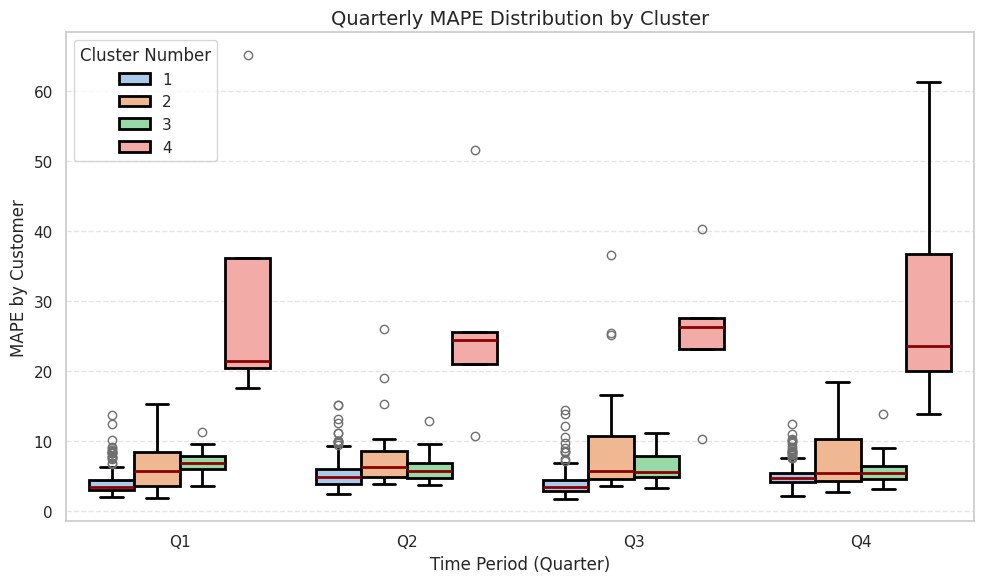

In [18]:
def plot_combined_quarterly_mape_boxplot(df_list, cluster_labels, mape_col='mape', days_per_customer=328, quarters=4):
    combined_df = pd.concat(
        [df.assign(cluster_num=label) for df, label in zip(df_list, cluster_labels)],
        ignore_index=True
    )

    combined_df[mape_col] = combined_df.mean(axis=1)
    total_rows = combined_df.shape[0]
    if total_rows % days_per_customer != 0:
        print(f"⚠️ Total rows ({total_rows}) not divisible by days_per_customer ({days_per_customer}).")
    num_customers = total_rows // days_per_customer
    quarter_length = days_per_customer // quarters
    combined_df['customer_id'] = combined_df.index // days_per_customer
    combined_df['day'] = combined_df.index % days_per_customer
    combined_df['quarter'] = (combined_df['day'] // quarter_length + 1).clip(upper=quarters)

    for cluster in combined_df["cluster_num"].unique():
        cluster_mask = combined_df["cluster_num"] == cluster
        combined_df.loc[cluster_mask, mape_col] = combined_df.loc[cluster_mask, mape_col].clip(
            lower=combined_df.loc[cluster_mask, mape_col].quantile(0.025),
            upper=combined_df.loc[cluster_mask, mape_col].quantile(0.975)
        )

    quarterly_mape = combined_df.groupby(['customer_id', 'quarter', 'cluster_num'])[mape_col].mean().reset_index()
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        data=quarterly_mape,
        x='quarter',
        y=mape_col,
        hue='cluster_num',
        palette="pastel",
        linewidth=2,
        boxprops=dict(edgecolor='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        medianprops=dict(color='darkred', linewidth=2)
    )

    plt.title("Quarterly MAPE Distribution by Cluster", fontsize=14)
    plt.xlabel("Time Period (Quarter)")
    plt.ylabel("MAPE by Customer")
    plt.xticks(ticks=range(quarters), labels=[f"Q{i+1}" for i in range(quarters)])
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.legend(title="Cluster Number")
    plt.tight_layout()
    plt.show()

# Example call
plot_combined_quarterly_mape_boxplot(all_mape_values, cluster_labels)

In [94]:
results = pd.read_csv(f'drive/MyDrive/ieor-project1/dataset/results_rnn_cluster{cluster_num}.csv')
results
results_4 = pd.read_csv(f'drive/MyDrive/ieor-project1/dataset/results_rnn_cluster4.csv')
results_4

,y_test,y_pred
0,1655.871091,1355.2294
1,1261.327377,1281.6820
2,1141.352904,1261.7917
3,1656.828334,1108.9702
4,1717.134652,1481.6881
...,...,...
1635,2158.069270,3252.7990
1636,1789.977892,2501.5564
1637,3349.299926,3132.6740
1638,3478.260870,3553.5847


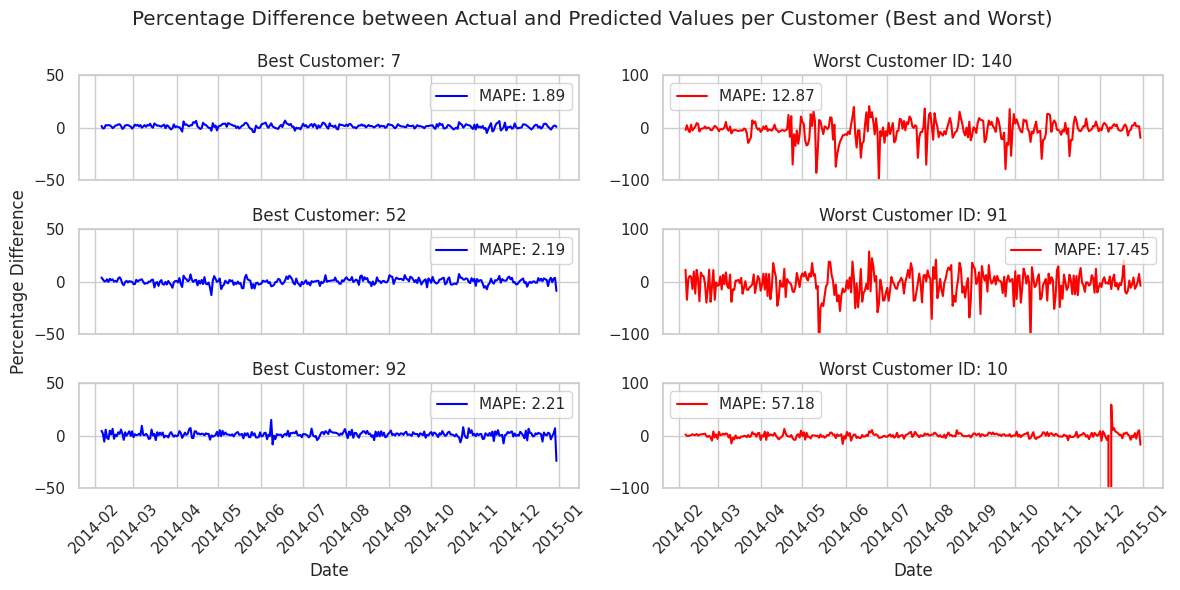

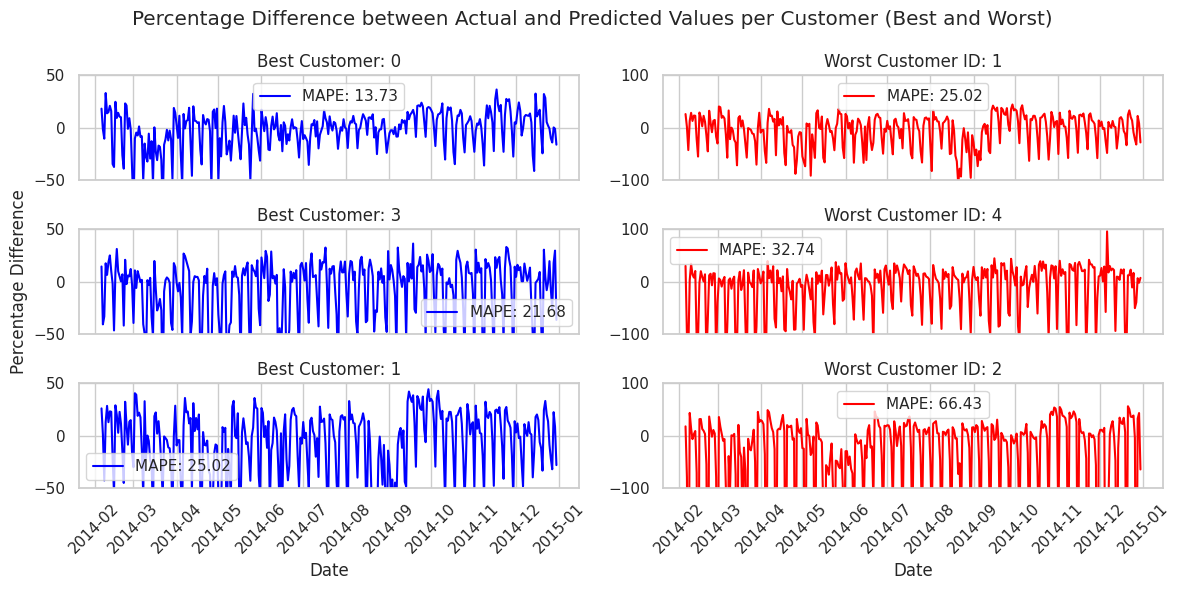

In [95]:
from datetime import datetime, timedelta

def plot_diff_per_customer(df):
    df = df.copy()
    df['diff'] = df['y_test'] - df['y_pred']

    # Create date range
    start_date = datetime(2014, 1, 1) + timedelta(days=36)
    df['customer_id'] = df.index // 328  # Assuming 328 is the number of days per customer
    df['day_index'] = df.groupby('customer_id').cumcount()
    df['date'] = df['day_index'].apply(lambda x: start_date + timedelta(days=x))
    df['diff_percentage'] = df['diff'] / df['y_test'] * 100
    df['absdiffpercentage'] = df['diff'].abs() / df['y_test'] * 100
    df['customer_mape'] = df.groupby('customer_id')['absdiffpercentage'].transform('mean')

    # Sort by customer_mape to get the best and worst customers
    df = df.sort_values(by=['customer_mape'])
    best_customers = df['customer_id'].unique()[:3]
    worst_customers = df['customer_id'].unique()[-3:]
    selected_customers = list(best_customers) + list(worst_customers)  # Combine best and worst

    # Create plot
    figsize = (12, 6)  # Set the figure size
    num_customers = len(selected_customers)

    # Create a subplot grid with 2 columns for best and worst
    fig, axes = plt.subplots(num_customers // 2, 2, figsize=figsize, sharex=True)
    # Plot best customers (in blue on the left)
    for i, customer_id in enumerate(best_customers):
        customer_data = df[df['customer_id'] == customer_id]
        label = round(customer_data['customer_mape'].unique()[0], 2)
        customer_data = customer_data.sort_values(by='date')
        # Plot on the left column (index 0)
        axes[i, 0].plot(customer_data['date'], customer_data['diff_percentage'], label=f'MAPE: {label}', color='blue')
        axes[1, 0].set_ylabel('Percentage Difference')
        axes[i, 0].legend()
        axes[i, 0].set_title(f'Best Customer: {customer_id}')
        # Set x-axis labels and rotation for the left axes
        axes[i, 0].set_ylim(-50, 50)

    # Plot worst customers (in red on the right)
    for i, customer_id in enumerate(worst_customers):
        customer_data = df[df['customer_id'] == customer_id]
        label = round(customer_data['customer_mape'].unique()[0], 2)
        customer_data = customer_data.sort_values(by='date')
        # Plot on the right column (index 1)
        axes[i, 1].plot(customer_data['date'], customer_data['diff_percentage'], label=f'MAPE: {label}', color='red')
        axes[i, 1].legend()
        axes[i, 1].set_title(f'Worst Customer ID: {customer_id}')
        # Set x-axis labels and rotation for the right axes
        axes[i, 1].set_ylim(-100, 100)

    axes[2, 0].set_xlabel('Date')
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[2, 1].set_xlabel('Date')
    axes[i, 1].tick_params(axis='x', rotation=45)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.suptitle('Percentage Difference between Actual and Predicted Values per Customer (Best and Worst)')
    plt.tight_layout()
    plt.show()
    # return df[df['customer_id'] == 10]


# Example call (replace results with your actual DataFrame)
check = plot_diff_per_customer(results)
check = plot_diff_per_customer(results_4)

In [75]:
check

,y_test,y_pred,diff,customer_id,day_index,date,diff_percentage,absdiffpercentage,customer_mape
3600,3249.777961,3512.6824,-262.904439,10,320,2014-12-23,-8.089920,8.089920,57.176569
3599,3537.134046,3544.0183,-6.884254,10,319,2014-12-22,-0.194628,0.194628,57.176569
3598,3595.707237,3534.1924,61.514837,10,318,2014-12-21,1.710785,1.710785,57.176569
3597,3660.546875,3446.3040,214.242875,10,317,2014-12-20,5.852756,5.852756,57.176569
3596,3598.063322,3477.0947,120.968622,10,316,2014-12-19,3.362048,3.362048,57.176569
...,...,...,...,...,...,...,...,...,...
3589,3443.223684,3183.1877,260.035984,10,309,2014-12-12,7.552108,7.552108,57.176569
3588,3311.743421,2849.0110,462.732421,10,308,2014-12-11,13.972472,13.972472,57.176569
3587,3485.990954,3122.5250,363.465954,10,307,2014-12-10,10.426474,10.426474,57.176569
3586,3192.294408,1312.5588,1879.735608,10,306,2014-12-09,58.883529,58.883529,57.176569
